In [ ]:
# @title Library install
!pip install Pillow==9.2.0
!pip install stable_baselines3
!git clone https://github.com/farm-gym/farm-gym-games
%cd farm-gym-games
!pip install git+https://github.com/farm-gym/farm-gym@3119a8568d7c16811a442f4f86e9d5fc02c6f7fc
!pip install --no-deps -e  .
!pip install -U gym
#!pip install GPy GPyOpt

print('Dependencies installed, run the next cell')
exit() # kill the runtime to update version of Pillow

In [1]:
#imports
import sys

import yaml
from farmgym.v2.entities.Birds import Birds
from farmgym.v2.entities.Cide import Cide
from farmgym.v2.entities.Facilities import Facility
from farmgym.v2.entities.Fertilizer import Fertilizer
from farmgym.v2.entities.Pests import Pests
from farmgym.v2.entities.Plant import Plant
from farmgym.v2.entities.Pollinators import Pollinators
from farmgym.v2.entities.Soil import Soil

## The following importe lines are import for the make_farm function that uses inspection module!
from farmgym.v2.entities.Weather import Weather
from farmgym.v2.entities.Weeds import Weeds
from farmgym.v2.farm import Farm
from farmgym.v2.farmers.BasicFarmer import BasicFarmer
from farmgym.v2.field import Field
from farmgym.v2.rules.BasicRule import BasicRule
from farmgym.v2.scorings.BasicScore import BasicScore

import os
from stable_baselines3 import PPO, DQN
from stable_baselines3.common.callbacks import BaseCallback
from stable_baselines3.common.evaluation import evaluate_policy
from farmgym_games.game_builder.utils_sb3 import farmgym_to_gym_observations_flattened, wrapper
#from farmgym_games.game_builder.make_farm import make_farm
from farmgym.v2.farm import generate_video
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

#from farmgym_games.game_catalogue.farm1.farm import env as Farm1

## Functions

In [2]:
#Make Farm Function
def make_farm(yamlfile):
    with open(yamlfile, "r", encoding="utf8") as file:
        farm_yaml = yaml.safe_load(file)

    farm = farm_yaml["Farm"]

    fields = []
    farmers = []
    for fi in farm:
        if "Field" in fi:
            entities = farm[fi]["entities"]
            ent = []
            for e in entities:
                k = (list(e.keys()))[0]
                c = getattr(sys.modules[__name__], k)
                # print("E",e, list(e.keys()), k,c)
                ent.append((c, str(e[k])))
            fields.append(
                Field(localization=farm[fi]["localization"], shape=farm[fi]["shape"], entities_specifications=ent)
            )
        if "Farmer" in fi:
            if farm[fi]["type"] == "basic":
                farmers.append(
                    BasicFarmer(
                        max_daily_interventions=farm[fi]["parameters"]["max_daily_interventions"],
                        max_daily_observations=farm[fi]["parameters"]["max_daily_observations"],
                    )
                )

    interaction_mode = farm_yaml["interaction_mode"]
    name = yamlfile[:-3]
    # TODO: Perhaps these names could be defined automatically? or actually
    #  remove the initailization file entirely, and proceed with init_values only.
    # name_score = name + "_" + farm_yaml["score"]
    # name_init = name + "_" + farm_yaml["initialization"]
    # name_actions = name + "_" + farm_yaml["actions"]

    scoring = BasicScore(score_configuration=farm_yaml["score"])

    rules = BasicRule(init_configuration=farm_yaml["initialization"], actions_configuration=farm_yaml["actions"])

    farm = Farm(
        fields=fields, farmers=farmers, scoring=scoring, rules=rules, policies=[], interaction_mode=interaction_mode
    )
    return farm

In [3]:
#Reward Logger Function
class RewardLogger(BaseCallback):
    def __init__(self, check_freq):
        super(RewardLogger, self).__init__()
        self.check_freq = check_freq
        self.episode_rewards = []
        self.episode_lengths = []
        self.cumulative_reward = 0  # Initialize the cumulative_reward here

    def _on_step(self) -> bool:
        self.cumulative_reward += self.locals['rewards'][0]  # Accumulate reward

        if self.locals['dones'][0]:
            # Episode done, log the cumulative reward and reset
            self.episode_rewards.append(self.cumulative_reward)
            self.cumulative_reward = 0

        return True


In [4]:
# Make environment function
def MakeEnv(filename):
    current_dir = %pwd
    print(current_dir)
    yaml_path = os.path.join(current_dir, filename)
    farm = make_farm(yaml_path)
    return farm

In [30]:
# smoothing function
def exponential_moving_average(values, weight=0.98):
    smoothed_values = []
    last = values[0]  # Start by setting the first value
    for val in values:
        smoothed_val = last * weight + (1 - weight) * val
        smoothed_values.append(smoothed_val)
        last = smoothed_val
    return smoothed_values



# Simple Farm 

In [6]:
#DQN simple train and eval
def train_and_evaluate_DQN_simple(seed):
    FarmSimple = MakeEnv("simple_farm.yaml")
    orignal_obs, _  = FarmSimple.reset()
    print(f"Original observation : \n{orignal_obs}\n")

    # Wrap to change observation and action spaces and the step function
    FarmSimple.farmgym_to_gym_observations = farmgym_to_gym_observations_flattened
    FarmSimple = wrapper(FarmSimple)
    obs, _ = FarmSimple.reset()
    print(f"Wrapped observation : \n{obs}\n")

    # Train the model
    print(f"training {seed}")
    reward_logger = RewardLogger(check_freq=1000)
    simplemodelDQN = DQN("MlpPolicy", FarmSimple, verbose=0)
    simplemodelDQN.learn(total_timesteps=100000, callback=reward_logger)
    if seed==2:
        simplemodelDQN.save("simplemodelDQN")

    # Evaluate the model
    print(f"testing{seed}")
    ep_rewards_dqn = []
    ep_numbers_dqn = []
    cr_dqn = 0 # Cumulative reward for the current episod
    obs, _ = FarmSimple.reset()
    ep_count_dqn = 0
    while True:
        if seed==2:
            if ep_count_dqn == 9:
                FarmSimple.render()
        obs = np.array(obs).reshape(1, -1) if isinstance(obs, list) else obs
        action, _states = simplemodelDQN.predict(obs)
        action = int(action[0]) if isinstance(action, np.ndarray) else action
        obs, rewards, dones, _, info = FarmSimple.step(action)
        cr_dqn += rewards
        
        if dones:  # Check if the episode is done
            ep_rewards_dqn.append(cr_dqn)
            ep_numbers_dqn.append(ep_count_dqn)
            obs, _ = FarmSimple.reset()
            #print(f"Episode Reward on evaluation was {cr}")
            cr_dqn=0
            ep_count_dqn+=1
            
            if ep_count_dqn==10:
                if seed==2:
                    generate_video(image_folder='.', video_name='simpledqn.avi')
                break
        
    return reward_logger.episode_rewards, ep_rewards_dqn

num_seeds = 3
all_train_rewards_dqn = []
all_test_rewards_dqn = []

for seed in range(num_seeds):
    train_rewards_dqn, test_rewards_dqn = train_and_evaluate_DQN_simple(seed)
    all_train_rewards_dqn.append(train_rewards_dqn)
    all_test_rewards_dqn.append(test_rewards_dqn)

# Find the maximum length of the reward lists
max_train_length = max(len(rewards) for rewards in all_train_rewards_dqn)
max_test_length = max(len(rewards) for rewards in all_test_rewards_dqn)

# Pad shorter reward lists with NaNs (or any other placeholder value)
padded_train_rewards = [np.pad(rewards, (0, max_train_length - len(rewards)), 
                               mode='constant', constant_values=np.nan) 
                        for rewards in all_train_rewards_dqn]
padded_test_rewards = [np.pad(rewards, (0, max_test_length - len(rewards)), 
                              mode='constant', constant_values=np.nan) 
                       for rewards in all_test_rewards_dqn]

# Convert lists to NumPy arrays
np_train_rewards = np.array(padded_train_rewards)
np_test_rewards = np.array(padded_test_rewards)

# Calculate the average, ignoring NaNs
average_train_rewards_dqn_simple = np.nanmean(np_train_rewards, axis=0)
average_test_rewards_dqn_simple = np.nanmean(np_test_rewards, axis=0)



c:\Users\Kai\Documents\Projects\CS_138\FinalProject\farms
Original observation : 
[{'Free': {'Field-0': {'Weather-0': {'day#int365': 1}}}}, {'Free': {'Field-0': {'Weather-0': {'air_temperature': {'max#°C': [8.857348792912802], 'mean#°C': [4.557348792912802], 'min#°C': [1.357348792912802]}}}}}, {'Free': {'Field-0': {'Weather-0': {'sun_exposure#int5': 2}}}}, {'Free': {'Field-0': {'Weather-0': {'rain_amount': 0}}}}, {'Free': {'Field-0': {'Weather-0': {'consecutive_dry#day': [1]}}}}, {'Free': {'Field-0': {'Soil-0': {'wet_surface#m2.day-1': {'[(0, 0)]': [0]}}}}}, {'Free': {'Field-0': {'Soil-0': {'microlife_health_index#%': {'[(0, 0)]': [70.0]}}}}}, {'Free': {'Field-0': {'Plant-0': {'stage': {'[(0, 0)]': 1}}}}}, {'Free': {'Field-0': {'Plant-0': {'size#cm': {'[(0, 0)]': [0]}}}}}, {'Free': {'Field-0': {'Plant-0': {'fruits_per_plant#nb': {'[(0, 0)]': [0]}}}}}, {'Free': {'Field-0': {'Plant-0': {'fruit_weight#g': {'[(0, 0)]': [0]}}}}}, {'Free': {'Field-1': {'Weather-0': {'day#int365': 1}}}}, {'Fr

In [7]:
#PPO simple train and eval
def train_and_evaluate_PPO_simple(seed):
    FarmSimple = MakeEnv("simple_farm.yaml")
    orignal_obs, _  = FarmSimple.reset()
    print(f"Original observation : \n{orignal_obs}\n")

    # Wrap to change observation and action spaces and the step function
    FarmSimple.farmgym_to_gym_observations = farmgym_to_gym_observations_flattened
    FarmSimple = wrapper(FarmSimple)
    obs, _ = FarmSimple.reset()
    print(f"Wrapped observation : \n{obs}\n")

    # Train the model
    print(f"train{seed}")
    reward_logger = RewardLogger(check_freq=1000)
    simplemodelPPO = PPO("MlpPolicy", FarmSimple, verbose=0)
    simplemodelPPO.learn(total_timesteps=100000, callback=reward_logger)
    if seed==2:
        simplemodelPPO.save("simplemodelPPO")

    print(f"test{seed}")
    ep_rewards_ppo = []
    ep_numbers_ppo = []
    cr_ppo = 0 # Cumulative reward for the current episod
    obs, _ = FarmSimple.reset()
    ep_count_ppo = 0
    while True:
        if seed==2:
            if ep_count_ppo == 9:
                FarmSimple.render()
        obs = np.array(obs).reshape(1, -1) if isinstance(obs, list) else obs
        action, _states = simplemodelPPO.predict(obs)
        action = int(action[0]) if isinstance(action, np.ndarray) else action
        obs, rewards, dones, _, info = FarmSimple.step(action)
        cr_ppo += rewards
        
        if dones:  # Check if the episode is done
            ep_rewards_ppo.append(cr_ppo)
            ep_numbers_ppo.append(ep_count_ppo)
            obs, _ = FarmSimple.reset()
            #print(f"Episode Reward on evaluation was {cr}")
            cr_ppo=0
            ep_count_ppo+=1
            
            if ep_count_ppo==10:
                if seed==2:
                    generate_video(image_folder='.', video_name='simpleppo.avi')
                break
        
    return reward_logger.episode_rewards, ep_rewards_ppo

num_seeds = 3
all_train_rewards_ppo = []
all_test_rewards_ppo = []

for seed in range(num_seeds):
    train_rewards_ppo, test_rewards_ppo = train_and_evaluate_PPO_simple(seed)
    all_train_rewards_ppo.append(train_rewards_ppo)
    all_test_rewards_ppo.append(test_rewards_ppo)

# Find the maximum length of the reward lists
max_train_length = max(len(rewards) for rewards in all_train_rewards_ppo)
max_test_length = max(len(rewards) for rewards in all_test_rewards_ppo)

# Pad shorter reward lists with NaNs (or any other placeholder value)
padded_train_rewards = [np.pad(rewards, (0, max_train_length - len(rewards)), 
                               mode='constant', constant_values=np.nan) 
                        for rewards in all_train_rewards_ppo]
padded_test_rewards = [np.pad(rewards, (0, max_test_length - len(rewards)), 
                              mode='constant', constant_values=np.nan) 
                       for rewards in all_test_rewards_ppo]

# Convert lists to NumPy arrays
np_train_rewards = np.array(padded_train_rewards)
np_test_rewards = np.array(padded_test_rewards)

# Calculate the average, ignoring NaNs
average_train_rewards_ppo_simple = np.nanmean(np_train_rewards, axis=0)
average_test_rewards_ppo_simple = np.nanmean(np_test_rewards, axis=0)




c:\Users\Kai\Documents\Projects\CS_138\FinalProject\farms
Original observation : 
[{'Free': {'Field-0': {'Weather-0': {'day#int365': 1}}}}, {'Free': {'Field-0': {'Weather-0': {'air_temperature': {'max#°C': [9.266817268720956], 'mean#°C': [4.9668172687209555], 'min#°C': [1.766817268720956]}}}}}, {'Free': {'Field-0': {'Weather-0': {'sun_exposure#int5': 1}}}}, {'Free': {'Field-0': {'Weather-0': {'rain_amount': 0}}}}, {'Free': {'Field-0': {'Weather-0': {'consecutive_dry#day': [1]}}}}, {'Free': {'Field-0': {'Soil-0': {'wet_surface#m2.day-1': {'[(0, 0)]': [0]}}}}}, {'Free': {'Field-0': {'Soil-0': {'microlife_health_index#%': {'[(0, 0)]': [70.0]}}}}}, {'Free': {'Field-0': {'Plant-0': {'stage': {'[(0, 0)]': 1}}}}}, {'Free': {'Field-0': {'Plant-0': {'size#cm': {'[(0, 0)]': [0]}}}}}, {'Free': {'Field-0': {'Plant-0': {'fruits_per_plant#nb': {'[(0, 0)]': [0]}}}}}, {'Free': {'Field-0': {'Plant-0': {'fruit_weight#g': {'[(0, 0)]': [0]}}}}}, {'Free': {'Field-1': {'Weather-0': {'day#int365': 1}}}}, {'F

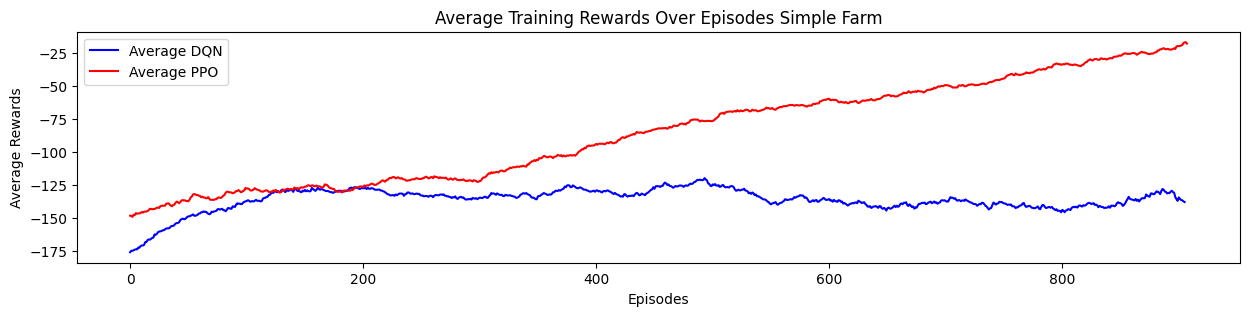

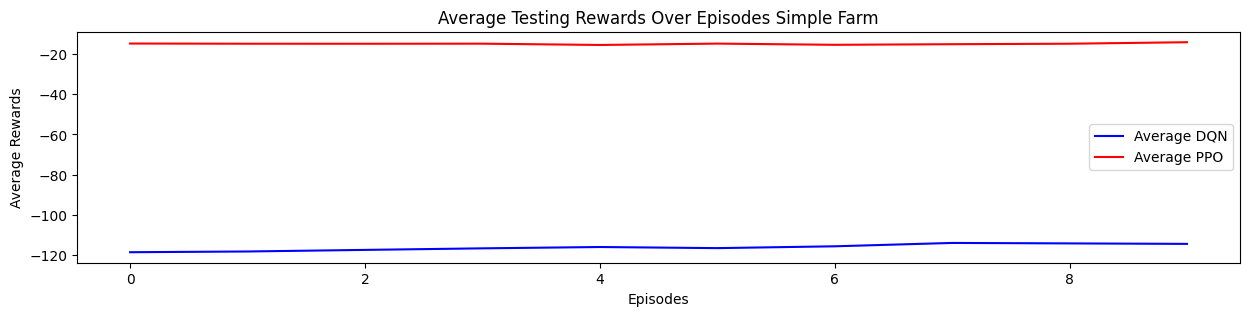

In [31]:
# Plotting Training Rewards
plt.figure(figsize=(15, 3))
plt.plot(exponential_moving_average(average_train_rewards_dqn_simple), label="Average DQN", color='blue')
plt.plot(exponential_moving_average(average_train_rewards_ppo_simple), label="Average PPO", color='red')
plt.xlabel('Episodes')
plt.ylabel('Average Rewards')
plt.title('Average Training Rewards Over Episodes Simple Farm')
plt.legend()
plt.show()

# Plotting Testing Rewards
plt.figure(figsize=(15, 3))
plt.plot(exponential_moving_average(average_test_rewards_dqn_simple), label="Average DQN", color='blue')
plt.plot(exponential_moving_average(average_test_rewards_ppo_simple), label="Average PPO", color='red')
plt.xlabel('Episodes')
plt.ylabel('Average Rewards')
plt.title('Average Testing Rewards Over Episodes Simple Farm')
plt.legend()
plt.show()

# Different Farm

## Transfer eval

In [9]:
# dqn diff transfer eval
def evaluate_DQN_diff_notune(seed):
    FarmDiff = MakeEnv("different_farm.yaml")
    orignal_obs, _  = FarmDiff.reset()
    print(f"Original observation : \n{orignal_obs}\n")

    # Wrap to change observation and action spaces and the step function
    FarmDiff.farmgym_to_gym_observations = farmgym_to_gym_observations_flattened
    FarmDiff = wrapper(FarmDiff)
    obs, _ = FarmDiff.reset()
    print(f"Wrapped observation : \n{obs}\n")

    model = DQN.load("simplemodelDQN", env= FarmDiff)
    # Evaluate the model
    print(f"testing{seed}")
    ep_rewards_dqn = []
    ep_numbers_dqn = []
    cr_dqn = 0 # Cumulative reward for the current episod
    obs, _ = FarmDiff.reset()
    ep_count_dqn = 0
    while True:
        if seed==2:
            if ep_count_dqn == 9:
                FarmDiff.render()
        obs = np.array(obs).reshape(1, -1) if isinstance(obs, list) else obs
        action, _states = model.predict(obs)
        action = int(action[0]) if isinstance(action, np.ndarray) else action
        obs, rewards, dones, _, info = FarmDiff.step(action)
        cr_dqn += rewards
        
        if dones:  # Check if the episode is done
            ep_rewards_dqn.append(cr_dqn)
            ep_numbers_dqn.append(ep_count_dqn)
            obs, _ = FarmDiff.reset()
            #print(f"Episode Reward on evaluation was {cr}")
            cr_dqn=0
            ep_count_dqn+=1
            
            if ep_count_dqn==10:
                if seed==2:
                    generate_video(image_folder='.', video_name='diffdqnTeval.avi')
                break
        
    return  ep_rewards_dqn

num_seeds = 3
all_test_rewards_dqn_diff_notune = []

for seed in range(num_seeds):
    test_rewards_dqn_diff_notune = evaluate_DQN_diff_notune(seed)
    all_test_rewards_dqn_diff_notune.append(test_rewards_dqn_diff_notune)

# Find the maximum length of the reward lists
max_test_length_dqn_diff_notune = max(len(rewards) for rewards in all_test_rewards_dqn_diff_notune)

# Pad shorter reward lists with NaNs (or any other placeholder value)
padded_test_rewards_dqn_diff_notune = [np.pad(rewards, (0, max_test_length_dqn_diff_notune - len(rewards)), 
                              mode='constant', constant_values=np.nan) 
                       for rewards in all_test_rewards_dqn_diff_notune]

# Convert lists to NumPy arrays
np_test_rewards_dqn_diff_notune = np.array(padded_test_rewards_dqn_diff_notune)

# Calculate the average, ignoring NaNs
average_test_rewards_dqn_diff_notune = np.nanmean(np_test_rewards_dqn_diff_notune, axis=0)



c:\Users\Kai\Documents\Projects\CS_138\FinalProject\farms
Original observation : 
[{'Free': {'Field-0': {'Weather-0': {'day#int365': 1}}}}, {'Free': {'Field-0': {'Weather-0': {'air_temperature': {'max#°C': [11.1], 'mean#°C': [5.767708333333334], 'min#°C': [0.4]}}}}}, {'Free': {'Field-0': {'Weather-0': {'sun_exposure#int5': 0}}}}, {'Free': {'Field-0': {'Weather-0': {'rain_amount': 2}}}}, {'Free': {'Field-0': {'Weather-0': {'consecutive_dry#day': [0]}}}}, {'Free': {'Field-0': {'Soil-0': {'wet_surface#m2.day-1': {'[(0, 0)]': [0]}}}}}, {'Free': {'Field-0': {'Soil-0': {'microlife_health_index#%': {'[(0, 0)]': [70.0]}}}}}, {'Free': {'Field-0': {'Plant-0': {'stage': {'[(0, 0)]': 1}}}}}, {'Free': {'Field-0': {'Plant-0': {'size#cm': {'[(0, 0)]': [0]}}}}}, {'Free': {'Field-0': {'Plant-0': {'fruits_per_plant#nb': {'[(0, 0)]': [0]}}}}}, {'Free': {'Field-0': {'Plant-0': {'fruit_weight#g': {'[(0, 0)]': [0]}}}}}, {'Free': {'Field-1': {'Weather-0': {'day#int365': 1}}}}, {'Free': {'Field-1': {'Weather-

In [10]:
#ppo diff transfer eval
def evaluate_PPO_diff_notune(seed):
    FarmDiff = MakeEnv("different_farm.yaml")
    orignal_obs, _  = FarmDiff.reset()
    print(f"Original observation : \n{orignal_obs}\n")

    # Wrap to change observation and action spaces and the step function
    FarmDiff.farmgym_to_gym_observations = farmgym_to_gym_observations_flattened
    FarmDiff = wrapper(FarmDiff)
    obs, _ = FarmDiff.reset()
    print(f"Wrapped observation : \n{obs}\n")

    model = PPO.load("simplemodelPPO", env= FarmDiff)
    # Evaluate the model
    print(f"testing{seed}")
    ep_rewards_ppo = []
    ep_numbers_ppo = []
    cr_ppo = 0 # Cumulative reward for the current episod
    obs, _ = FarmDiff.reset()
    ep_count_ppo = 0
    while True:
        if seed==2:
            if ep_count_ppo == 9:
                FarmDiff.render()
        obs = np.array(obs).reshape(1, -1) if isinstance(obs, list) else obs
        action, _states = model.predict(obs)
        action = int(action[0]) if isinstance(action, np.ndarray) else action
        obs, rewards, dones, _, info = FarmDiff.step(action)
        cr_ppo += rewards
        
        if dones:  # Check if the episode is done
            ep_rewards_ppo.append(cr_ppo)
            ep_numbers_ppo.append(ep_count_ppo)
            obs, _ = FarmDiff.reset()
            #print(f"Episode Reward on evaluation was {cr}")
            cr_ppo=0
            ep_count_ppo+=1
            
            if ep_count_ppo==10:
                if seed==2:
                    generate_video(image_folder='.', video_name='diffppoTeval.avi')
                break
        
    return  ep_rewards_ppo

num_seeds = 3
all_test_rewards_ppo_diff_notune = []

for seed in range(num_seeds):
    test_rewards_ppo_diff_notune = evaluate_PPO_diff_notune(seed)
    all_test_rewards_ppo_diff_notune.append(test_rewards_ppo_diff_notune)

# Find the maximum length of the reward lists
max_test_length_ppo_diff_notune = max(len(rewards) for rewards in all_test_rewards_ppo_diff_notune)

# Pad shorter reward lists with NaNs (or any other placeholder value)
padded_test_rewards_ppo_diff_notune = [np.pad(rewards, (0, max_test_length_ppo_diff_notune - len(rewards)), 
                              mode='constant', constant_values=np.nan) 
                       for rewards in all_test_rewards_ppo_diff_notune]

# Convert lists to NumPy arrays
np_test_rewards_ppo_diff_notune = np.array(padded_test_rewards_ppo_diff_notune)

# Calculate the average, ignoring NaNs
average_test_rewards_ppo_diff_notune = np.nanmean(np_test_rewards_ppo_diff_notune, axis=0)



c:\Users\Kai\Documents\Projects\CS_138\FinalProject\farms
Original observation : 
[{'Free': {'Field-0': {'Weather-0': {'day#int365': 1}}}}, {'Free': {'Field-0': {'Weather-0': {'air_temperature': {'max#°C': [11.1], 'mean#°C': [5.767708333333334], 'min#°C': [0.4]}}}}}, {'Free': {'Field-0': {'Weather-0': {'sun_exposure#int5': 0}}}}, {'Free': {'Field-0': {'Weather-0': {'rain_amount': 1}}}}, {'Free': {'Field-0': {'Weather-0': {'consecutive_dry#day': [0]}}}}, {'Free': {'Field-0': {'Soil-0': {'wet_surface#m2.day-1': {'[(0, 0)]': [0]}}}}}, {'Free': {'Field-0': {'Soil-0': {'microlife_health_index#%': {'[(0, 0)]': [70.0]}}}}}, {'Free': {'Field-0': {'Plant-0': {'stage': {'[(0, 0)]': 1}}}}}, {'Free': {'Field-0': {'Plant-0': {'size#cm': {'[(0, 0)]': [0]}}}}}, {'Free': {'Field-0': {'Plant-0': {'fruits_per_plant#nb': {'[(0, 0)]': [0]}}}}}, {'Free': {'Field-0': {'Plant-0': {'fruit_weight#g': {'[(0, 0)]': [0]}}}}}, {'Free': {'Field-1': {'Weather-0': {'day#int365': 1}}}}, {'Free': {'Field-1': {'Weather-

## transfer train and eval

In [11]:
# dqn diff transfer train and eval
def train_and_evaluate_DQN_Tdiff(seed):
    FarmDiff = MakeEnv("different_farm.yaml")
    orignal_obs, _  = FarmDiff.reset()
    print(f"Original observation : \n{orignal_obs}\n")

    # Wrap to change observation and action spaces and the step function
    FarmDiff.farmgym_to_gym_observations = farmgym_to_gym_observations_flattened
    FarmDiff = wrapper(FarmDiff)
    obs, _ = FarmDiff.reset()
    print(f"Wrapped observation : \n{obs}\n")

    # Train the model
    print(f"training {seed}")
    model = DQN.load("simplemodelDQN", env= FarmDiff)
    reward_logger = RewardLogger(check_freq=1000)
    model.learn(total_timesteps=100000, callback=reward_logger)
    if seed==2:
        model.save("simplemodelDQNTDiff")
    
    # Evaluate the model
    print(f"testing{seed}")
    ep_rewards_dqn = []
    ep_numbers_dqn = []
    cr_dqn = 0 # Cumulative reward for the current episod
    obs, _ = FarmDiff.reset()
    ep_count_dqn = 0
    while True:
        if seed==2:
            if ep_count_dqn == 9:
                FarmDiff.render()
        obs = np.array(obs).reshape(1, -1) if isinstance(obs, list) else obs
        action, _states = model.predict(obs)
        action = int(action[0]) if isinstance(action, np.ndarray) else action
        obs, rewards, dones, _, info = FarmDiff.step(action)
        cr_dqn += rewards
        
        if dones:  # Check if the episode is done
            ep_rewards_dqn.append(cr_dqn)
            ep_numbers_dqn.append(ep_count_dqn)
            obs, _ = FarmDiff.reset()
            #print(f"Episode Reward on evaluation was {cr}")
            cr_dqn=0
            ep_count_dqn+=1
            
            if ep_count_dqn==10:
                if seed==2:
                    generate_video(image_folder='.', video_name='diffdqnT.avi')
                break
        
    return reward_logger.episode_rewards, ep_rewards_dqn

num_seeds = 3
all_train_rewards_dqn_Tdiff = []
all_test_rewards_dqn_Tdiff = []

for seed in range(num_seeds):
    train_rewards_dqn_Tdiff, test_rewards_dqn_Tdiff = train_and_evaluate_DQN_Tdiff(seed)
    all_train_rewards_dqn_Tdiff.append(train_rewards_dqn_Tdiff)
    all_test_rewards_dqn_Tdiff.append(test_rewards_dqn_Tdiff)

# Find the maximum length of the reward lists
max_train_length_dqn_Tdiff = max(len(rewards) for rewards in all_train_rewards_dqn_Tdiff)
max_test_length_dqn_Tdiff = max(len(rewards) for rewards in all_test_rewards_dqn_Tdiff)

# Pad shorter reward lists with NaNs (or any other placeholder value)
padded_train_rewards_dqn_Tdiff = [np.pad(rewards, (0, max_train_length_dqn_Tdiff - len(rewards)), 
                               mode='constant', constant_values=np.nan) 
                        for rewards in all_train_rewards_dqn_Tdiff]
padded_test_rewards_dqn_Tdiff = [np.pad(rewards, (0, max_test_length_dqn_Tdiff - len(rewards)), 
                              mode='constant', constant_values=np.nan) 
                       for rewards in all_test_rewards_dqn_Tdiff]

# Convert lists to NumPy arrays
np_train_rewards_dqn_Tdiff = np.array(padded_train_rewards_dqn_Tdiff)
np_test_rewards_dqn_Tdiff = np.array(padded_test_rewards_dqn_Tdiff)

# Calculate the average, ignoring NaNs
average_train_rewards_dqn_Tdiff = np.nanmean(np_train_rewards_dqn_Tdiff, axis=0)
average_test_rewards_dqn_Tdiff = np.nanmean(np_test_rewards_dqn_Tdiff, axis=0)



c:\Users\Kai\Documents\Projects\CS_138\FinalProject\farms
Original observation : 
[{'Free': {'Field-0': {'Weather-0': {'day#int365': 1}}}}, {'Free': {'Field-0': {'Weather-0': {'air_temperature': {'max#°C': [11.1], 'mean#°C': [5.767708333333334], 'min#°C': [0.4]}}}}}, {'Free': {'Field-0': {'Weather-0': {'sun_exposure#int5': 0}}}}, {'Free': {'Field-0': {'Weather-0': {'rain_amount': 2}}}}, {'Free': {'Field-0': {'Weather-0': {'consecutive_dry#day': [0]}}}}, {'Free': {'Field-0': {'Soil-0': {'wet_surface#m2.day-1': {'[(0, 0)]': [0]}}}}}, {'Free': {'Field-0': {'Soil-0': {'microlife_health_index#%': {'[(0, 0)]': [70.0]}}}}}, {'Free': {'Field-0': {'Plant-0': {'stage': {'[(0, 0)]': 1}}}}}, {'Free': {'Field-0': {'Plant-0': {'size#cm': {'[(0, 0)]': [0]}}}}}, {'Free': {'Field-0': {'Plant-0': {'fruits_per_plant#nb': {'[(0, 0)]': [0]}}}}}, {'Free': {'Field-0': {'Plant-0': {'fruit_weight#g': {'[(0, 0)]': [0]}}}}}, {'Free': {'Field-1': {'Weather-0': {'day#int365': 1}}}}, {'Free': {'Field-1': {'Weather-

In [12]:
# ppo diff transfer train and eval
def train_and_evaluate_PPO_Tdiff(seed):
    FarmDiff = MakeEnv("different_farm.yaml")
    orignal_obs, _  = FarmDiff.reset()
    print(f"Original observation : \n{orignal_obs}\n")

    # Wrap to change observation and action spaces and the step function
    FarmDiff.farmgym_to_gym_observations = farmgym_to_gym_observations_flattened
    FarmDiff = wrapper(FarmDiff)
    obs, _ = FarmDiff.reset()
    print(f"Wrapped observation : \n{obs}\n")

    # Train the model
    print(f"training {seed}")
    model = PPO.load("simplemodelPPO", env= FarmDiff)
    reward_logger = RewardLogger(check_freq=1000)
    model.learn(total_timesteps=100000, callback=reward_logger)
    if seed==2:
        model.save("simplemodelPPOTDiff")
    
    # Evaluate the model
    print(f"testing{seed}")
    ep_rewards_ppo = []
    ep_numbers_ppo = []
    cr_ppo = 0 # Cumulative reward for the current episod
    obs, _ = FarmDiff.reset()
    ep_count_ppo = 0
    while True:
        if seed==2:
            if ep_count_ppo == 9:
                FarmDiff.render()
        obs = np.array(obs).reshape(1, -1) if isinstance(obs, list) else obs
        action, _states = model.predict(obs)
        action = int(action[0]) if isinstance(action, np.ndarray) else action
        obs, rewards, dones, _, info = FarmDiff.step(action)
        cr_ppo += rewards
        
        if dones:  # Check if the episode is done
            ep_rewards_ppo.append(cr_ppo)
            ep_numbers_ppo.append(ep_count_ppo)
            obs, _ = FarmDiff.reset()
            #print(f"Episode Reward on evaluation was {cr}")
            cr_ppo=0
            ep_count_ppo+=1
            
            if ep_count_ppo==10:
                if seed==2:
                    generate_video(image_folder='.', video_name='diffppoT.avi')
                break
        
    return reward_logger.episode_rewards, ep_rewards_ppo

num_seeds = 3
all_train_rewards_ppo_Tdiff = []
all_test_rewards_ppo_Tdiff = []

for seed in range(num_seeds):
    train_rewards_ppo_Tdiff, test_rewards_ppo_Tdiff = train_and_evaluate_PPO_Tdiff(seed)
    all_train_rewards_ppo_Tdiff.append(train_rewards_ppo_Tdiff)
    all_test_rewards_ppo_Tdiff.append(test_rewards_ppo_Tdiff)

# Find the maximum length of the reward lists
max_train_length_ppo_Tdiff = max(len(rewards) for rewards in all_train_rewards_ppo_Tdiff)
max_test_length_ppo_Tdiff = max(len(rewards) for rewards in all_test_rewards_ppo_Tdiff)

# Pad shorter reward lists with NaNs (or any other placeholder value)
padded_train_rewards_ppo_Tdiff = [np.pad(rewards, (0, max_train_length_ppo_Tdiff - len(rewards)), 
                               mode='constant', constant_values=np.nan) 
                        for rewards in all_train_rewards_ppo_Tdiff]
padded_test_rewards_ppo_Tdiff = [np.pad(rewards, (0, max_test_length_ppo_Tdiff - len(rewards)), 
                              mode='constant', constant_values=np.nan) 
                       for rewards in all_test_rewards_ppo_Tdiff]

# Convert lists to NumPy arrays
np_train_rewards_ppo_Tdiff = np.array(padded_train_rewards_ppo_Tdiff)
np_test_rewards_ppo_Tdiff = np.array(padded_test_rewards_ppo_Tdiff)

# Calculate the average, ignoring NaNs
average_train_rewards_ppo_Tdiff = np.nanmean(np_train_rewards_ppo_Tdiff, axis=0)
average_test_rewards_ppo_Tdiff = np.nanmean(np_test_rewards_ppo_Tdiff, axis=0)



c:\Users\Kai\Documents\Projects\CS_138\FinalProject\farms
Original observation : 
[{'Free': {'Field-0': {'Weather-0': {'day#int365': 1}}}}, {'Free': {'Field-0': {'Weather-0': {'air_temperature': {'max#°C': [11.1], 'mean#°C': [5.767708333333334], 'min#°C': [0.4]}}}}}, {'Free': {'Field-0': {'Weather-0': {'sun_exposure#int5': 0}}}}, {'Free': {'Field-0': {'Weather-0': {'rain_amount': 1}}}}, {'Free': {'Field-0': {'Weather-0': {'consecutive_dry#day': [0]}}}}, {'Free': {'Field-0': {'Soil-0': {'wet_surface#m2.day-1': {'[(0, 0)]': [0]}}}}}, {'Free': {'Field-0': {'Soil-0': {'microlife_health_index#%': {'[(0, 0)]': [70.0]}}}}}, {'Free': {'Field-0': {'Plant-0': {'stage': {'[(0, 0)]': 1}}}}}, {'Free': {'Field-0': {'Plant-0': {'size#cm': {'[(0, 0)]': [0]}}}}}, {'Free': {'Field-0': {'Plant-0': {'fruits_per_plant#nb': {'[(0, 0)]': [0]}}}}}, {'Free': {'Field-0': {'Plant-0': {'fruit_weight#g': {'[(0, 0)]': [0]}}}}}, {'Free': {'Field-1': {'Weather-0': {'day#int365': 1}}}}, {'Free': {'Field-1': {'Weather-

## different baseline

In [13]:
# dqn diff train and eval
def train_and_evaluate_DQN_diff(seed):
    FarmDiff = MakeEnv("different_farm.yaml")
    orignal_obs, _  = FarmDiff.reset()
    print(f"Original observation : \n{orignal_obs}\n")

    # Wrap to change observation and action spaces and the step function
    FarmDiff.farmgym_to_gym_observations = farmgym_to_gym_observations_flattened
    FarmDiff = wrapper(FarmDiff)
    obs, _ = FarmDiff.reset()
    print(f"Wrapped observation : \n{obs}\n")

    # Train the model
    print(f"training {seed}")
    model = DQN("MlpPolicy", FarmDiff, verbose=0)
    reward_logger = RewardLogger(check_freq=1000)
    model.learn(total_timesteps=100000, callback=reward_logger)
    if seed==2:
        model.save("simplemodelDQNDiff")
    
    # Evaluate the model
    print(f"testing{seed}")
    ep_rewards_dqn = []
    ep_numbers_dqn = []
    cr_dqn = 0 # Cumulative reward for the current episod
    obs, _ = FarmDiff.reset()
    ep_count_dqn = 0
    while True:
        if seed==2:
            if ep_count_dqn == 9:
                FarmDiff.render()
        obs = np.array(obs).reshape(1, -1) if isinstance(obs, list) else obs
        action, _states = model.predict(obs)
        action = int(action[0]) if isinstance(action, np.ndarray) else action
        obs, rewards, dones, _, info = FarmDiff.step(action)
        cr_dqn += rewards
        
        if dones:  # Check if the episode is done
            ep_rewards_dqn.append(cr_dqn)
            ep_numbers_dqn.append(ep_count_dqn)
            obs, _ = FarmDiff.reset()
            #print(f"Episode Reward on evaluation was {cr}")
            cr_dqn=0
            ep_count_dqn+=1
            
            if ep_count_dqn==10:
                if seed==2:
                    generate_video(image_folder='.', video_name='diffdqn.avi')
                break
        
    return reward_logger.episode_rewards, ep_rewards_dqn

num_seeds = 3
all_train_rewards_dqn_diff = []
all_test_rewards_dqn_diff = []

for seed in range(num_seeds):
    train_rewards_dqn_diff, test_rewards_dqn_diff = train_and_evaluate_DQN_diff(seed)
    all_train_rewards_dqn_diff.append(train_rewards_dqn_diff)
    all_test_rewards_dqn_diff.append(test_rewards_dqn_diff)

# Find the maximum length of the reward lists
max_train_length_dqn_diff = max(len(rewards) for rewards in all_train_rewards_dqn_diff)
max_test_length_dqn_diff = max(len(rewards) for rewards in all_test_rewards_dqn_diff)

# Pad shorter reward lists with NaNs (or any other placeholder value)
padded_train_rewards_dqn_diff = [np.pad(rewards, (0, max_train_length_dqn_diff - len(rewards)), 
                               mode='constant', constant_values=np.nan) 
                        for rewards in all_train_rewards_dqn_diff]
padded_test_rewards_dqn_diff = [np.pad(rewards, (0, max_test_length_dqn_diff - len(rewards)), 
                              mode='constant', constant_values=np.nan) 
                       for rewards in all_test_rewards_dqn_diff]

# Convert lists to NumPy arrays
np_train_rewards_dqn_diff = np.array(padded_train_rewards_dqn_diff)
np_test_rewards_dqn_diff = np.array(padded_test_rewards_dqn_diff)

# Calculate the average, ignoring NaNs
average_train_rewards_dqn_diff = np.nanmean(np_train_rewards_dqn_diff, axis=0)
average_test_rewards_dqn_diff = np.nanmean(np_test_rewards_dqn_diff, axis=0)



c:\Users\Kai\Documents\Projects\CS_138\FinalProject\farms
Original observation : 
[{'Free': {'Field-0': {'Weather-0': {'day#int365': 1}}}}, {'Free': {'Field-0': {'Weather-0': {'air_temperature': {'max#°C': [11.1], 'mean#°C': [5.767708333333334], 'min#°C': [0.4]}}}}}, {'Free': {'Field-0': {'Weather-0': {'sun_exposure#int5': 0}}}}, {'Free': {'Field-0': {'Weather-0': {'rain_amount': 2}}}}, {'Free': {'Field-0': {'Weather-0': {'consecutive_dry#day': [0]}}}}, {'Free': {'Field-0': {'Soil-0': {'wet_surface#m2.day-1': {'[(0, 0)]': [0]}}}}}, {'Free': {'Field-0': {'Soil-0': {'microlife_health_index#%': {'[(0, 0)]': [70.0]}}}}}, {'Free': {'Field-0': {'Plant-0': {'stage': {'[(0, 0)]': 1}}}}}, {'Free': {'Field-0': {'Plant-0': {'size#cm': {'[(0, 0)]': [0]}}}}}, {'Free': {'Field-0': {'Plant-0': {'fruits_per_plant#nb': {'[(0, 0)]': [0]}}}}}, {'Free': {'Field-0': {'Plant-0': {'fruit_weight#g': {'[(0, 0)]': [0]}}}}}, {'Free': {'Field-1': {'Weather-0': {'day#int365': 1}}}}, {'Free': {'Field-1': {'Weather-

In [14]:
# ppo diff train and eval
def train_and_evaluate_PPO_diff(seed):
    FarmDiff = MakeEnv("different_farm.yaml")
    orignal_obs, _  = FarmDiff.reset()
    print(f"Original observation : \n{orignal_obs}\n")

    # Wrap to change observation and action spaces and the step function
    FarmDiff.farmgym_to_gym_observations = farmgym_to_gym_observations_flattened
    FarmDiff = wrapper(FarmDiff)
    obs, _ = FarmDiff.reset()
    print(f"Wrapped observation : \n{obs}\n")

    # Train the model
    print(f"training {seed}")
    model = PPO("MlpPolicy", FarmDiff, verbose=0)
    reward_logger = RewardLogger(check_freq=1000)
    model.learn(total_timesteps=100000, callback=reward_logger)
    if seed==2:
        model.save("simplemodelPPODiff")
    
    # Evaluate the model
    print(f"testing{seed}")
    ep_rewards_ppo = []
    ep_numbers_ppo = []
    cr_ppo = 0 # Cumulative reward for the current episod
    obs, _ = FarmDiff.reset()
    ep_count_ppo = 0
    while True:
        if seed==2:
            if ep_count_ppo == 9:
                FarmDiff.render()
        obs = np.array(obs).reshape(1, -1) if isinstance(obs, list) else obs
        action, _states = model.predict(obs)
        action = int(action[0]) if isinstance(action, np.ndarray) else action
        obs, rewards, dones, _, info = FarmDiff.step(action)
        cr_ppo += rewards
        
        if dones:  # Check if the episode is done
            ep_rewards_ppo.append(cr_ppo)
            ep_numbers_ppo.append(ep_count_ppo)
            obs, _ = FarmDiff.reset()
            #print(f"Episode Reward on evaluation was {cr}")
            cr_ppo=0
            ep_count_ppo+=1
            
            if ep_count_ppo==10:
                if seed==2:
                    generate_video(image_folder='.', video_name='diffppo.avi')
                break
        
    return reward_logger.episode_rewards, ep_rewards_ppo

num_seeds = 3
all_train_rewards_ppo_diff = []
all_test_rewards_ppo_diff = []

for seed in range(num_seeds):
    train_rewards_ppo_diff, test_rewards_ppo_diff = train_and_evaluate_PPO_diff(seed)
    all_train_rewards_ppo_diff.append(train_rewards_ppo_diff)
    all_test_rewards_ppo_diff.append(test_rewards_ppo_diff)

# Find the maximum length of the reward lists
max_train_length_ppo_diff = max(len(rewards) for rewards in all_train_rewards_ppo_diff)
max_test_length_ppo_diff = max(len(rewards) for rewards in all_test_rewards_ppo_diff)

# Pad shorter reward lists with NaNs (or any other placeholder value)
padded_train_rewards_ppo_diff = [np.pad(rewards, (0, max_train_length_ppo_diff - len(rewards)), 
                               mode='constant', constant_values=np.nan) 
                        for rewards in all_train_rewards_ppo_diff]
padded_test_rewards_ppo_diff = [np.pad(rewards, (0, max_test_length_ppo_diff - len(rewards)), 
                              mode='constant', constant_values=np.nan) 
                       for rewards in all_test_rewards_ppo_diff]

# Convert lists to NumPy arrays
np_train_rewards_ppo_diff = np.array(padded_train_rewards_ppo_diff)
np_test_rewards_ppo_diff = np.array(padded_test_rewards_ppo_diff)

# Calculate the average, ignoring NaNs
average_train_rewards_ppo_diff = np.nanmean(np_train_rewards_ppo_diff, axis=0)
average_test_rewards_ppo_diff = np.nanmean(np_test_rewards_ppo_diff, axis=0)



c:\Users\Kai\Documents\Projects\CS_138\FinalProject\farms
Original observation : 
[{'Free': {'Field-0': {'Weather-0': {'day#int365': 1}}}}, {'Free': {'Field-0': {'Weather-0': {'air_temperature': {'max#°C': [11.1], 'mean#°C': [5.767708333333334], 'min#°C': [0.4]}}}}}, {'Free': {'Field-0': {'Weather-0': {'sun_exposure#int5': 0}}}}, {'Free': {'Field-0': {'Weather-0': {'rain_amount': 2}}}}, {'Free': {'Field-0': {'Weather-0': {'consecutive_dry#day': [0]}}}}, {'Free': {'Field-0': {'Soil-0': {'wet_surface#m2.day-1': {'[(0, 0)]': [0]}}}}}, {'Free': {'Field-0': {'Soil-0': {'microlife_health_index#%': {'[(0, 0)]': [70.0]}}}}}, {'Free': {'Field-0': {'Plant-0': {'stage': {'[(0, 0)]': 1}}}}}, {'Free': {'Field-0': {'Plant-0': {'size#cm': {'[(0, 0)]': [0]}}}}}, {'Free': {'Field-0': {'Plant-0': {'fruits_per_plant#nb': {'[(0, 0)]': [0]}}}}}, {'Free': {'Field-0': {'Plant-0': {'fruit_weight#g': {'[(0, 0)]': [0]}}}}}, {'Free': {'Field-1': {'Weather-0': {'day#int365': 1}}}}, {'Free': {'Field-1': {'Weather-

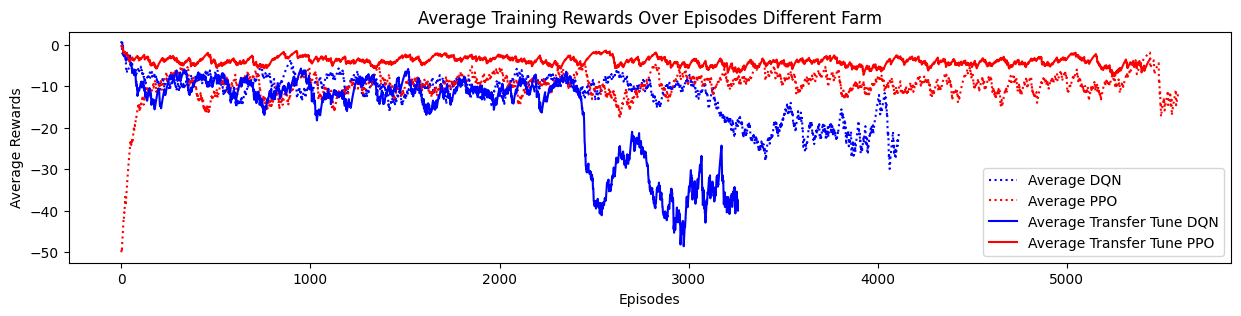

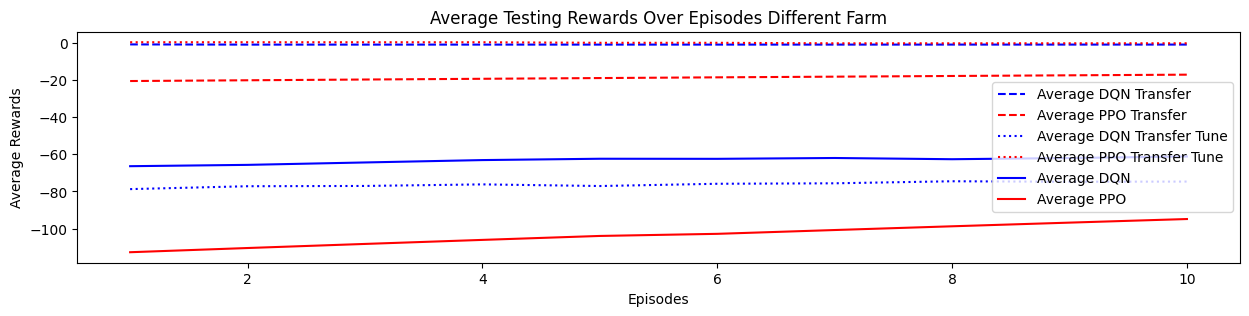

In [32]:
# Plotting Training Rewards
plt.figure(figsize=(15, 3))
plt.plot(exponential_moving_average(average_train_rewards_dqn_diff), label="Average DQN", color="blue", linestyle=':')
plt.plot(exponential_moving_average(average_train_rewards_ppo_diff), label="Average PPO",color="red", linestyle=':')
plt.plot(exponential_moving_average(average_train_rewards_dqn_Tdiff), label="Average Transfer Tune DQN",color="blue")
plt.plot(exponential_moving_average(average_train_rewards_ppo_Tdiff), label="Average Transfer Tune PPO",color="red")
plt.xlabel('Episodes')
plt.ylabel('Average Rewards')
plt.title('Average Training Rewards Over Episodes Different Farm')
plt.legend()
plt.show()

# Plotting Testing Rewards
plt.figure(figsize=(15, 3))
plt.plot(range(1, len(average_test_rewards_dqn_simple) + 1), exponential_moving_average(average_test_rewards_dqn_diff_notune), label="Average DQN Transfer",color="blue", linestyle='--')
plt.plot(range(1, len(average_test_rewards_ppo_simple) + 1), exponential_moving_average(average_test_rewards_ppo_diff_notune), label="Average PPO Transfer",color="red", linestyle='--')
plt.plot(range(1, len(average_test_rewards_dqn_simple) + 1), exponential_moving_average(average_test_rewards_dqn_Tdiff), label="Average DQN Transfer Tune",color="blue", linestyle=':')
plt.plot(range(1, len(average_test_rewards_ppo_simple) + 1), exponential_moving_average(average_test_rewards_ppo_Tdiff), label="Average PPO Transfer Tune",color="red", linestyle=':')
plt.plot(range(1, len(average_test_rewards_dqn_simple) + 1), exponential_moving_average(average_test_rewards_dqn_diff), label="Average DQN", color='blue')
plt.plot(range(1, len(average_test_rewards_ppo_simple) + 1), exponential_moving_average(average_test_rewards_ppo_diff), label="Average PPO", color='red')
plt.xlabel('Episodes')
plt.ylabel('Average Rewards')
plt.title('Average Testing Rewards Over Episodes Different Farm')
plt.legend()
plt.show()

# Polyculture Farm

## Transfer eval

In [16]:
# dqn poly transfer eval
def evaluate_DQN_Poly_notune(seed):
    FarmPoly = MakeEnv("polyculture_farm.yaml")
    orignal_obs, _  = FarmPoly.reset()
    print(f"Original observation : \n{orignal_obs}\n")

    # Wrap to change observation and action spaces and the step function
    FarmPoly.farmgym_to_gym_observations = farmgym_to_gym_observations_flattened
    FarmPoly = wrapper(FarmPoly)
    obs, _ = FarmPoly.reset()
    print(f"Wrapped observation : \n{obs}\n")

    model = DQN.load("simplemodelDQN", env= FarmPoly)
    # Evaluate the model
    print(f"testing{seed}")
    ep_rewards_dqn = []
    ep_numbers_dqn = []
    cr_dqn = 0 # Cumulative reward for the current episod
    obs, _ = FarmPoly.reset()
    ep_count_dqn = 0
    while True:
        if seed==2:
            if ep_count_dqn == 9:
                FarmPoly.render()
        obs = np.array(obs).reshape(1, -1) if isinstance(obs, list) else obs
        action, _states = model.predict(obs)
        action = int(action[0]) if isinstance(action, np.ndarray) else action
        obs, rewards, dones, _, info = FarmPoly.step(action)
        cr_dqn += rewards
        
        if dones:  # Check if the episode is done
            ep_rewards_dqn.append(cr_dqn)
            ep_numbers_dqn.append(ep_count_dqn)
            obs, _ = FarmPoly.reset()
            #print(f"Episode Reward on evaluation was {cr}")
            cr_dqn=0
            ep_count_dqn+=1
            
            if ep_count_dqn==10:
                if seed==2:
                    generate_video(image_folder='.', video_name='polydqnTeval.avi')
                break
        
    return  ep_rewards_dqn

num_seeds = 3
all_test_rewards_dqn_Poly_notune = []

for seed in range(num_seeds):
    test_rewards_dqn_Poly_notune = evaluate_DQN_Poly_notune(seed)
    all_test_rewards_dqn_Poly_notune.append(test_rewards_dqn_Poly_notune)

# Find the maximum length of the reward lists
max_test_length_dqn_Poly_notune = max(len(rewards) for rewards in all_test_rewards_dqn_Poly_notune)

# Pad shorter reward lists with NaNs (or any other placeholder value)
padded_test_rewards_dqn_Poly_notune = [np.pad(rewards, (0, max_test_length_dqn_Poly_notune - len(rewards)), 
                              mode='constant', constant_values=np.nan) 
                       for rewards in all_test_rewards_dqn_Poly_notune]

# Convert lists to NumPy arrays
np_test_rewards_dqn_Poly_notune = np.array(padded_test_rewards_dqn_Poly_notune)

# Calculate the average, ignoring NaNs
average_test_rewards_dqn_Poly_notune = np.nanmean(np_test_rewards_dqn_Poly_notune, axis=0)



c:\Users\Kai\Documents\Projects\CS_138\FinalProject\farms
Original observation : 
[{'Free': {'Field-0': {'Weather-0': {'day#int365': 1}}}}, {'Free': {'Field-0': {'Weather-0': {'air_temperature': {'max#°C': [9.078626702284321], 'mean#°C': [4.778626702284321], 'min#°C': [1.5786267022843214]}}}}}, {'Free': {'Field-0': {'Weather-0': {'sun_exposure#int5': 0}}}}, {'Free': {'Field-0': {'Weather-0': {'rain_amount': 0}}}}, {'Free': {'Field-0': {'Weather-0': {'consecutive_dry#day': [1]}}}}, {'Free': {'Field-0': {'Soil-0': {'wet_surface#m2.day-1': {'[(0, 0)]': [0]}}}}}, {'Free': {'Field-0': {'Soil-0': {'microlife_health_index#%': {'[(0, 0)]': [70.0]}}}}}, {'Free': {'Field-0': {'Plant-0': {'stage': {'[(0, 0)]': 1}}}}}, {'Free': {'Field-0': {'Plant-0': {'size#cm': {'[(0, 0)]': [0]}}}}}, {'Free': {'Field-0': {'Plant-0': {'fruits_per_plant#nb': {'[(0, 0)]': [0]}}}}}, {'Free': {'Field-0': {'Plant-0': {'fruit_weight#g': {'[(0, 0)]': [0]}}}}}, {'Free': {'Field-1': {'Weather-0': {'day#int365': 1}}}}, {'F

In [17]:
# ppo poly transfer eval
def evaluate_PPO_Poly_notune(seed):
    FarmPoly = MakeEnv("polyculture_farm.yaml")
    orignal_obs, _  = FarmPoly.reset()
    print(f"Original observation : \n{orignal_obs}\n")

    # Wrap to change observation and action spaces and the step function
    FarmPoly.farmgym_to_gym_observations = farmgym_to_gym_observations_flattened
    FarmPoly = wrapper(FarmPoly)
    obs, _ = FarmPoly.reset()
    print(f"Wrapped observation : \n{obs}\n")

    model = PPO.load("simplemodelPPO", env= FarmPoly)
    # Evaluate the model
    print(f"testing{seed}")
    ep_rewards_ppo = []
    ep_numbers_ppo = []
    cr_ppo = 0 # Cumulative reward for the current episod
    obs, _ = FarmPoly.reset()
    ep_count_ppo = 0
    while True:
        if seed==2:
            if ep_count_ppo == 9:
                FarmPoly.render()
        obs = np.array(obs).reshape(1, -1) if isinstance(obs, list) else obs
        action, _states = model.predict(obs)
        action = int(action[0]) if isinstance(action, np.ndarray) else action
        obs, rewards, dones, _, info = FarmPoly.step(action)
        cr_ppo += rewards
        
        if dones:  # Check if the episode is done
            ep_rewards_ppo.append(cr_ppo)
            ep_numbers_ppo.append(ep_count_ppo)
            obs, _ = FarmPoly.reset()
            #print(f"Episode Reward on evaluation was {cr}")
            cr_ppo=0
            ep_count_ppo+=1
            
            if ep_count_ppo==10:
                if seed==2:
                    generate_video(image_folder='.', video_name='polyppoTeval.avi')
                break
        
    return  ep_rewards_ppo

num_seeds = 3
all_test_rewards_ppo_Poly_notune = []

for seed in range(num_seeds):
    test_rewards_ppo_Poly_notune = evaluate_PPO_Poly_notune(seed)
    all_test_rewards_ppo_Poly_notune.append(test_rewards_ppo_Poly_notune)

# Find the maximum length of the reward lists
max_test_length_ppo_Poly_notune = max(len(rewards) for rewards in all_test_rewards_ppo_Poly_notune)

# Pad shorter reward lists with NaNs (or any other placeholder value)
padded_test_rewards_ppo_Poly_notune = [np.pad(rewards, (0, max_test_length_ppo_Poly_notune - len(rewards)), 
                              mode='constant', constant_values=np.nan) 
                       for rewards in all_test_rewards_ppo_Poly_notune]

# Convert lists to NumPy arrays
np_test_rewards_ppo_Poly_notune = np.array(padded_test_rewards_ppo_Poly_notune)

# Calculate the average, ignoring NaNs
average_test_rewards_ppo_Poly_notune = np.nanmean(np_test_rewards_ppo_Poly_notune, axis=0)



c:\Users\Kai\Documents\Projects\CS_138\FinalProject\farms
Original observation : 
[{'Free': {'Field-0': {'Weather-0': {'day#int365': 1}}}}, {'Free': {'Field-0': {'Weather-0': {'air_temperature': {'max#°C': [8.867897708728405], 'mean#°C': [4.567897708728405], 'min#°C': [1.3678977087284054]}}}}}, {'Free': {'Field-0': {'Weather-0': {'sun_exposure#int5': 1}}}}, {'Free': {'Field-0': {'Weather-0': {'rain_amount': 0}}}}, {'Free': {'Field-0': {'Weather-0': {'consecutive_dry#day': [1]}}}}, {'Free': {'Field-0': {'Soil-0': {'wet_surface#m2.day-1': {'[(0, 0)]': [0]}}}}}, {'Free': {'Field-0': {'Soil-0': {'microlife_health_index#%': {'[(0, 0)]': [70.0]}}}}}, {'Free': {'Field-0': {'Plant-0': {'stage': {'[(0, 0)]': 1}}}}}, {'Free': {'Field-0': {'Plant-0': {'size#cm': {'[(0, 0)]': [0]}}}}}, {'Free': {'Field-0': {'Plant-0': {'fruits_per_plant#nb': {'[(0, 0)]': [0]}}}}}, {'Free': {'Field-0': {'Plant-0': {'fruit_weight#g': {'[(0, 0)]': [0]}}}}}, {'Free': {'Field-1': {'Weather-0': {'day#int365': 1}}}}, {'F

## Transfer train and eval

In [18]:
# dqn poly transfer train and eval
def train_and_evaluate_DQN_TPoly(seed):
    FarmPoly = MakeEnv("polyculture_farm.yaml")
    orignal_obs, _  = FarmPoly.reset()
    print(f"Original observation : \n{orignal_obs}\n")

    # Wrap to change observation and action spaces and the step function
    FarmPoly.farmgym_to_gym_observations = farmgym_to_gym_observations_flattened
    FarmPoly = wrapper(FarmPoly)
    obs, _ = FarmPoly.reset()
    print(f"Wrapped observation : \n{obs}\n")

    # Train the model
    print(f"training {seed}")
    model = DQN.load("simplemodelDQN", env= FarmPoly)
    reward_logger = RewardLogger(check_freq=1000)
    model.learn(total_timesteps=100000, callback=reward_logger)
    if seed==2:
        model.save("simplemodelDQNTPoly")
    
    # Evaluate the model
    print(f"testing{seed}")
    ep_rewards_dqn = []
    ep_numbers_dqn = []
    cr_dqn = 0 # Cumulative reward for the current episod
    obs, _ = FarmPoly.reset()
    ep_count_dqn = 0
    while True:
        if seed==2:
            if ep_count_dqn == 9:
                FarmPoly.render()
        obs = np.array(obs).reshape(1, -1) if isinstance(obs, list) else obs
        action, _states = model.predict(obs)
        action = int(action[0]) if isinstance(action, np.ndarray) else action
        obs, rewards, dones, _, info = FarmPoly.step(action)
        cr_dqn += rewards
        
        if dones:  # Check if the episode is done
            ep_rewards_dqn.append(cr_dqn)
            ep_numbers_dqn.append(ep_count_dqn)
            obs, _ = FarmPoly.reset()
            #print(f"Episode Reward on evaluation was {cr}")
            cr_dqn=0
            ep_count_dqn+=1
            
            if ep_count_dqn==10:
                if seed==2:
                    generate_video(image_folder='.', video_name='polydqnT.avi')
                break
        
    return reward_logger.episode_rewards, ep_rewards_dqn

num_seeds = 3
all_train_rewards_dqn_TPoly = []
all_test_rewards_dqn_TPoly = []

for seed in range(num_seeds):
    train_rewards_dqn_TPoly, test_rewards_dqn_TPoly = train_and_evaluate_DQN_TPoly(seed)
    all_train_rewards_dqn_TPoly.append(train_rewards_dqn_TPoly)
    all_test_rewards_dqn_TPoly.append(test_rewards_dqn_TPoly)

# Find the maximum length of the reward lists
max_train_length_dqn_TPoly = max(len(rewards) for rewards in all_train_rewards_dqn_TPoly)
max_test_length_dqn_TPoly = max(len(rewards) for rewards in all_test_rewards_dqn_TPoly)

# Pad shorter reward lists with NaNs (or any other placeholder value)
padded_train_rewards_dqn_TPoly = [np.pad(rewards, (0, max_train_length_dqn_TPoly - len(rewards)), 
                               mode='constant', constant_values=np.nan) 
                        for rewards in all_train_rewards_dqn_TPoly]
padded_test_rewards_dqn_TPoly = [np.pad(rewards, (0, max_test_length_dqn_TPoly - len(rewards)), 
                              mode='constant', constant_values=np.nan) 
                       for rewards in all_test_rewards_dqn_TPoly]

# Convert lists to NumPy arrays
np_train_rewards_dqn_TPoly = np.array(padded_train_rewards_dqn_TPoly)
np_test_rewards_dqn_TPoly = np.array(padded_test_rewards_dqn_TPoly)

# Calculate the average, ignoring NaNs
average_train_rewards_dqn_TPoly = np.nanmean(np_train_rewards_dqn_TPoly, axis=0)
average_test_rewards_dqn_TPoly = np.nanmean(np_test_rewards_dqn_TPoly, axis=0)



c:\Users\Kai\Documents\Projects\CS_138\FinalProject\farms
Original observation : 
[{'Free': {'Field-0': {'Weather-0': {'day#int365': 1}}}}, {'Free': {'Field-0': {'Weather-0': {'air_temperature': {'max#°C': [9.136591433844481], 'mean#°C': [4.836591433844481], 'min#°C': [1.636591433844481]}}}}}, {'Free': {'Field-0': {'Weather-0': {'sun_exposure#int5': 0}}}}, {'Free': {'Field-0': {'Weather-0': {'rain_amount': 0}}}}, {'Free': {'Field-0': {'Weather-0': {'consecutive_dry#day': [1]}}}}, {'Free': {'Field-0': {'Soil-0': {'wet_surface#m2.day-1': {'[(0, 0)]': [0]}}}}}, {'Free': {'Field-0': {'Soil-0': {'microlife_health_index#%': {'[(0, 0)]': [70.0]}}}}}, {'Free': {'Field-0': {'Plant-0': {'stage': {'[(0, 0)]': 1}}}}}, {'Free': {'Field-0': {'Plant-0': {'size#cm': {'[(0, 0)]': [0]}}}}}, {'Free': {'Field-0': {'Plant-0': {'fruits_per_plant#nb': {'[(0, 0)]': [0]}}}}}, {'Free': {'Field-0': {'Plant-0': {'fruit_weight#g': {'[(0, 0)]': [0]}}}}}, {'Free': {'Field-1': {'Weather-0': {'day#int365': 1}}}}, {'Fr

In [19]:
# ppo poly transfer train and eval
def train_and_evaluate_PPO_TPoly(seed):
    FarmPoly = MakeEnv("polyculture_farm.yaml")
    orignal_obs, _  = FarmPoly.reset()
    print(f"Original observation : \n{orignal_obs}\n")

    # Wrap to change observation and action spaces and the step function
    FarmPoly.farmgym_to_gym_observations = farmgym_to_gym_observations_flattened
    FarmPoly = wrapper(FarmPoly)
    obs, _ = FarmPoly.reset()
    print(f"Wrapped observation : \n{obs}\n")

    # Train the model
    print(f"training {seed}")
    model = PPO.load("simplemodelPPO", env= FarmPoly)
    reward_logger = RewardLogger(check_freq=1000)
    model.learn(total_timesteps=100000, callback=reward_logger)
    if seed==2:
        model.save("simplemodelPPOTPoly")
    
    # Evaluate the model
    print(f"testing{seed}")
    ep_rewards_ppo = []
    ep_numbers_ppo = []
    cr_ppo = 0 # Cumulative reward for the current episod
    obs, _ = FarmPoly.reset()
    ep_count_ppo = 0
    while True:
        if seed==2:
            if ep_count_ppo == 9:
                FarmPoly.render()
        obs = np.array(obs).reshape(1, -1) if isinstance(obs, list) else obs
        action, _states = model.predict(obs)
        action = int(action[0]) if isinstance(action, np.ndarray) else action
        obs, rewards, dones, _, info = FarmPoly.step(action)
        cr_ppo += rewards
        
        if dones:  # Check if the episode is done
            ep_rewards_ppo.append(cr_ppo)
            ep_numbers_ppo.append(ep_count_ppo)
            obs, _ = FarmPoly.reset()
            #print(f"Episode Reward on evaluation was {cr}")
            cr_ppo=0
            ep_count_ppo+=1
            
            if ep_count_ppo==10:
                if seed==2:
                    generate_video(image_folder='.', video_name='polyppoT.avi')
                break
        
    return reward_logger.episode_rewards, ep_rewards_ppo

num_seeds = 3
all_train_rewards_ppo_TPoly = []
all_test_rewards_ppo_TPoly = []

for seed in range(num_seeds):
    train_rewards_ppo_TPoly, test_rewards_ppo_TPoly = train_and_evaluate_PPO_TPoly(seed)
    all_train_rewards_ppo_TPoly.append(train_rewards_ppo_TPoly)
    all_test_rewards_ppo_TPoly.append(test_rewards_ppo_TPoly)

# Find the maximum length of the reward lists
max_train_length_ppo_TPoly = max(len(rewards) for rewards in all_train_rewards_ppo_TPoly)
max_test_length_ppo_TPoly = max(len(rewards) for rewards in all_test_rewards_ppo_TPoly)

# Pad shorter reward lists with NaNs (or any other placeholder value)
padded_train_rewards_ppo_TPoly = [np.pad(rewards, (0, max_train_length_ppo_TPoly - len(rewards)), 
                               mode='constant', constant_values=np.nan) 
                        for rewards in all_train_rewards_ppo_TPoly]
padded_test_rewards_ppo_TPoly = [np.pad(rewards, (0, max_test_length_ppo_TPoly - len(rewards)), 
                              mode='constant', constant_values=np.nan) 
                       for rewards in all_test_rewards_ppo_TPoly]

# Convert lists to NumPy arrays
np_train_rewards_ppo_TPoly = np.array(padded_train_rewards_ppo_TPoly)
np_test_rewards_ppo_TPoly = np.array(padded_test_rewards_ppo_TPoly)

# Calculate the average, ignoring NaNs
average_train_rewards_ppo_TPoly = np.nanmean(np_train_rewards_ppo_TPoly, axis=0)
average_test_rewards_ppo_TPoly = np.nanmean(np_test_rewards_ppo_TPoly, axis=0)



c:\Users\Kai\Documents\Projects\CS_138\FinalProject\farms
Original observation : 
[{'Free': {'Field-0': {'Weather-0': {'day#int365': 1}}}}, {'Free': {'Field-0': {'Weather-0': {'air_temperature': {'max#°C': [9.23058657892037], 'mean#°C': [4.93058657892037], 'min#°C': [1.7305865789203705]}}}}}, {'Free': {'Field-0': {'Weather-0': {'sun_exposure#int5': 1}}}}, {'Free': {'Field-0': {'Weather-0': {'rain_amount': 0}}}}, {'Free': {'Field-0': {'Weather-0': {'consecutive_dry#day': [1]}}}}, {'Free': {'Field-0': {'Soil-0': {'wet_surface#m2.day-1': {'[(0, 0)]': [0]}}}}}, {'Free': {'Field-0': {'Soil-0': {'microlife_health_index#%': {'[(0, 0)]': [70.0]}}}}}, {'Free': {'Field-0': {'Plant-0': {'stage': {'[(0, 0)]': 1}}}}}, {'Free': {'Field-0': {'Plant-0': {'size#cm': {'[(0, 0)]': [0]}}}}}, {'Free': {'Field-0': {'Plant-0': {'fruits_per_plant#nb': {'[(0, 0)]': [0]}}}}}, {'Free': {'Field-0': {'Plant-0': {'fruit_weight#g': {'[(0, 0)]': [0]}}}}}, {'Free': {'Field-1': {'Weather-0': {'day#int365': 1}}}}, {'Fre

## Polyculture baseline

In [20]:
# dqn poly train and eval
def train_and_evaluate_DQN_Poly(seed):
    FarmPoly = MakeEnv("polyculture_farm.yaml")
    orignal_obs, _  = FarmPoly.reset()
    print(f"Original observation : \n{orignal_obs}\n")

    # Wrap to change observation and action spaces and the step function
    FarmPoly.farmgym_to_gym_observations = farmgym_to_gym_observations_flattened
    FarmPoly = wrapper(FarmPoly)
    obs, _ = FarmPoly.reset()
    print(f"Wrapped observation : \n{obs}\n")

    # Train the model
    print(f"training {seed}")
    model = DQN("MlpPolicy", FarmPoly, verbose=0)
    reward_logger = RewardLogger(check_freq=1000)
    model.learn(total_timesteps=100000, callback=reward_logger)
    if seed==2:
        model.save("simplemodelDQNPoly")
    
    # Evaluate the model
    print(f"testing{seed}")
    ep_rewards_dqn = []
    ep_numbers_dqn = []
    cr_dqn = 0 # Cumulative reward for the current episod
    obs, _ = FarmPoly.reset()
    ep_count_dqn = 0
    while True:
        if seed==2:
            if ep_count_dqn == 9:
                FarmPoly.render()
        obs = np.array(obs).reshape(1, -1) if isinstance(obs, list) else obs
        action, _states = model.predict(obs)
        action = int(action[0]) if isinstance(action, np.ndarray) else action
        obs, rewards, dones, _, info = FarmPoly.step(action)
        cr_dqn += rewards
        
        if dones:  # Check if the episode is done
            ep_rewards_dqn.append(cr_dqn)
            ep_numbers_dqn.append(ep_count_dqn)
            obs, _ = FarmPoly.reset()
            #print(f"Episode Reward on evaluation was {cr}")
            cr_dqn=0
            ep_count_dqn+=1
            
            if ep_count_dqn==10:
                if seed==2:
                    generate_video(image_folder='.', video_name='polydqn.avi')
                break
        
    return reward_logger.episode_rewards, ep_rewards_dqn

num_seeds = 3
all_train_rewards_dqn_Poly = []
all_test_rewards_dqn_Poly = []

for seed in range(num_seeds):
    train_rewards_dqn_Poly, test_rewards_dqn_Poly = train_and_evaluate_DQN_Poly(seed)
    all_train_rewards_dqn_Poly.append(train_rewards_dqn_Poly)
    all_test_rewards_dqn_Poly.append(test_rewards_dqn_Poly)

# Find the maximum length of the reward lists
max_train_length_dqn_Poly = max(len(rewards) for rewards in all_train_rewards_dqn_Poly)
max_test_length_dqn_Poly = max(len(rewards) for rewards in all_test_rewards_dqn_Poly)

# Pad shorter reward lists with NaNs (or any other placeholder value)
padded_train_rewards_dqn_Poly = [np.pad(rewards, (0, max_train_length_dqn_Poly - len(rewards)), 
                               mode='constant', constant_values=np.nan) 
                        for rewards in all_train_rewards_dqn_Poly]
padded_test_rewards_dqn_Poly = [np.pad(rewards, (0, max_test_length_dqn_Poly - len(rewards)), 
                              mode='constant', constant_values=np.nan) 
                       for rewards in all_test_rewards_dqn_Poly]

# Convert lists to NumPy arrays
np_train_rewards_dqn_Poly = np.array(padded_train_rewards_dqn_Poly)
np_test_rewards_dqn_Poly = np.array(padded_test_rewards_dqn_Poly)

# Calculate the average, ignoring NaNs
average_train_rewards_dqn_Poly = np.nanmean(np_train_rewards_dqn_Poly, axis=0)
average_test_rewards_dqn_Poly = np.nanmean(np_test_rewards_dqn_Poly, axis=0)



c:\Users\Kai\Documents\Projects\CS_138\FinalProject\farms
Original observation : 
[{'Free': {'Field-0': {'Weather-0': {'day#int365': 1}}}}, {'Free': {'Field-0': {'Weather-0': {'air_temperature': {'max#°C': [9.069370327649526], 'mean#°C': [4.769370327649526], 'min#°C': [1.569370327649526]}}}}}, {'Free': {'Field-0': {'Weather-0': {'sun_exposure#int5': 0}}}}, {'Free': {'Field-0': {'Weather-0': {'rain_amount': 0}}}}, {'Free': {'Field-0': {'Weather-0': {'consecutive_dry#day': [1]}}}}, {'Free': {'Field-0': {'Soil-0': {'wet_surface#m2.day-1': {'[(0, 0)]': [0]}}}}}, {'Free': {'Field-0': {'Soil-0': {'microlife_health_index#%': {'[(0, 0)]': [70.0]}}}}}, {'Free': {'Field-0': {'Plant-0': {'stage': {'[(0, 0)]': 1}}}}}, {'Free': {'Field-0': {'Plant-0': {'size#cm': {'[(0, 0)]': [0]}}}}}, {'Free': {'Field-0': {'Plant-0': {'fruits_per_plant#nb': {'[(0, 0)]': [0]}}}}}, {'Free': {'Field-0': {'Plant-0': {'fruit_weight#g': {'[(0, 0)]': [0]}}}}}, {'Free': {'Field-1': {'Weather-0': {'day#int365': 1}}}}, {'Fr

In [21]:
# ppo poly train and eval
def train_and_evaluate_PPO_Poly(seed):
    FarmPoly = MakeEnv("polyculture_farm.yaml")
    orignal_obs, _  = FarmPoly.reset()
    print(f"Original observation : \n{orignal_obs}\n")

    # Wrap to change observation and action spaces and the step function
    FarmPoly.farmgym_to_gym_observations = farmgym_to_gym_observations_flattened
    FarmPoly = wrapper(FarmPoly)
    obs, _ = FarmPoly.reset()
    print(f"Wrapped observation : \n{obs}\n")

    # Train the model
    print(f"training {seed}")
    model = PPO("MlpPolicy", FarmPoly, verbose=0)
    reward_logger = RewardLogger(check_freq=1000)
    model.learn(total_timesteps=100000, callback=reward_logger)
    if seed==2:
        model.save("simplemodelPPOPoly")
    
    # Evaluate the model
    print(f"testing{seed}")
    ep_rewards_ppo = []
    ep_numbers_ppo = []
    cr_ppo = 0 # Cumulative reward for the current episod
    obs, _ = FarmPoly.reset()
    ep_count_ppo = 0
    while True:
        if seed==2:
            if ep_count_ppo == 9:
                FarmPoly.render()
        obs = np.array(obs).reshape(1, -1) if isinstance(obs, list) else obs
        action, _states = model.predict(obs)
        action = int(action[0]) if isinstance(action, np.ndarray) else action
        obs, rewards, dones, _, info = FarmPoly.step(action)
        cr_ppo += rewards
        
        if dones:  # Check if the episode is done
            ep_rewards_ppo.append(cr_ppo)
            ep_numbers_ppo.append(ep_count_ppo)
            obs, _ = FarmPoly.reset()
            #print(f"Episode Reward on evaluation was {cr}")
            cr_ppo=0
            ep_count_ppo+=1
            
            if ep_count_ppo==10:
                if seed==2:
                    generate_video(image_folder='.', video_name='polyppo.avi')
                break
        
    return reward_logger.episode_rewards, ep_rewards_ppo

num_seeds = 3
all_train_rewards_ppo_Poly = []
all_test_rewards_ppo_Poly = []

for seed in range(num_seeds):
    train_rewards_ppo_Poly, test_rewards_ppo_Poly = train_and_evaluate_PPO_Poly(seed)
    all_train_rewards_ppo_Poly.append(train_rewards_ppo_Poly)
    all_test_rewards_ppo_Poly.append(test_rewards_ppo_Poly)

# Find the maximum length of the reward lists
max_train_length_ppo_Poly = max(len(rewards) for rewards in all_train_rewards_ppo_Poly)
max_test_length_ppo_Poly = max(len(rewards) for rewards in all_test_rewards_ppo_Poly)

# Pad shorter reward lists with NaNs (or any other placeholder value)
padded_train_rewards_ppo_Poly = [np.pad(rewards, (0, max_train_length_ppo_Poly - len(rewards)), 
                               mode='constant', constant_values=np.nan) 
                        for rewards in all_train_rewards_ppo_Poly]
padded_test_rewards_ppo_Poly = [np.pad(rewards, (0, max_test_length_ppo_Poly - len(rewards)), 
                              mode='constant', constant_values=np.nan) 
                       for rewards in all_test_rewards_ppo_Poly]

# Convert lists to NumPy arrays
np_train_rewards_ppo_Poly = np.array(padded_train_rewards_ppo_Poly)
np_test_rewards_ppo_Poly = np.array(padded_test_rewards_ppo_Poly)

# Calculate the average, ignoring NaNs
average_train_rewards_ppo_Poly = np.nanmean(np_train_rewards_ppo_Poly, axis=0)
average_test_rewards_ppo_Poly = np.nanmean(np_test_rewards_ppo_Poly, axis=0)



c:\Users\Kai\Documents\Projects\CS_138\FinalProject\farms
Original observation : 
[{'Free': {'Field-0': {'Weather-0': {'day#int365': 1}}}}, {'Free': {'Field-0': {'Weather-0': {'air_temperature': {'max#°C': [8.971168233014758], 'mean#°C': [4.671168233014758], 'min#°C': [1.4711682330147589]}}}}}, {'Free': {'Field-0': {'Weather-0': {'sun_exposure#int5': 1}}}}, {'Free': {'Field-0': {'Weather-0': {'rain_amount': 0}}}}, {'Free': {'Field-0': {'Weather-0': {'consecutive_dry#day': [1]}}}}, {'Free': {'Field-0': {'Soil-0': {'wet_surface#m2.day-1': {'[(0, 0)]': [0]}}}}}, {'Free': {'Field-0': {'Soil-0': {'microlife_health_index#%': {'[(0, 0)]': [70.0]}}}}}, {'Free': {'Field-0': {'Plant-0': {'stage': {'[(0, 0)]': 1}}}}}, {'Free': {'Field-0': {'Plant-0': {'size#cm': {'[(0, 0)]': [0]}}}}}, {'Free': {'Field-0': {'Plant-0': {'fruits_per_plant#nb': {'[(0, 0)]': [0]}}}}}, {'Free': {'Field-0': {'Plant-0': {'fruit_weight#g': {'[(0, 0)]': [0]}}}}}, {'Free': {'Field-1': {'Weather-0': {'day#int365': 1}}}}, {'F

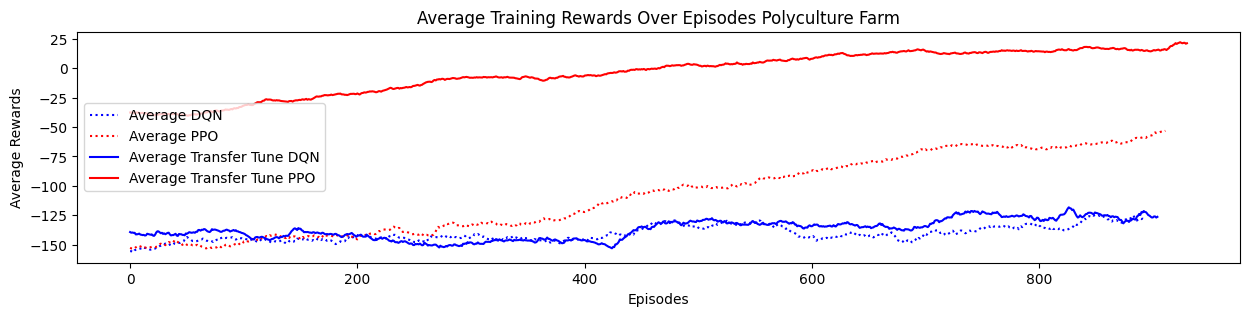

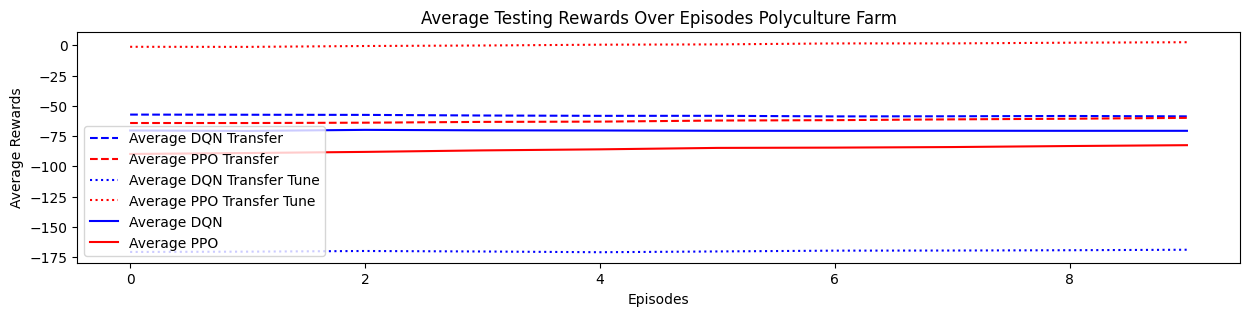

In [33]:
# Plotting Training Rewards
plt.figure(figsize=(15, 3))
plt.plot(exponential_moving_average(average_train_rewards_dqn_Poly), label="Average DQN", color="blue", linestyle=':')
plt.plot(exponential_moving_average(average_train_rewards_ppo_Poly), label="Average PPO",color="red", linestyle=':')
plt.plot(exponential_moving_average(average_train_rewards_dqn_TPoly), label="Average Transfer Tune DQN",color="blue")
plt.plot(exponential_moving_average(average_train_rewards_ppo_TPoly), label="Average Transfer Tune PPO",color="red")
plt.xlabel('Episodes')
plt.ylabel('Average Rewards')
plt.title('Average Training Rewards Over Episodes Polyculture Farm')
plt.legend()
plt.show()

# Plotting Testing Rewards
plt.figure(figsize=(15, 3))
plt.plot( exponential_moving_average(average_test_rewards_dqn_Poly_notune), label="Average DQN Transfer",color="blue", linestyle='--')
plt.plot( exponential_moving_average(average_test_rewards_ppo_Poly_notune), label="Average PPO Transfer",color="red", linestyle='--')
plt.plot( exponential_moving_average(average_test_rewards_dqn_TPoly), label="Average DQN Transfer Tune",color="blue", linestyle=':')
plt.plot( exponential_moving_average(average_test_rewards_ppo_TPoly), label="Average PPO Transfer Tune",color="red", linestyle=':')
plt.plot( exponential_moving_average(average_test_rewards_dqn_Poly), label="Average DQN", color='blue')
plt.plot( exponential_moving_average(average_test_rewards_ppo_Poly), label="Average PPO", color='red')
plt.xlabel('Episodes')
plt.ylabel('Average Rewards')
plt.title('Average Testing Rewards Over Episodes Polyculture Farm')
plt.legend()
plt.show()